### Informacje dotyczące pomiarów:

* Pomiary czasu dla funkcji odwracania uwzględniają czasy działania algorytmu mnożenia macierzy (tutaj Binet)
* Pomiary czasu dla funckji eliminacji Gaussowskiej uwzględniają czasy działania algorytmów odwracania macierzy i mnożenia macierzy
* W ramach zliczania operacji zmiennoprzecnikowych zliczano operacje na macierzach
* Pliki .csv zawierające pomiary egzekucji algorytmów na maszynie z procesorem i5 13-400f będą nazywane <nazwa_algorytmu>_results_i5_13400f.csv

### Przygotowanie importów do przetworzenia wyników:

Poniższą komórkę wystarczy uruchomić jeden raz.

In [ ]:
# using Pkg
# Pkg.add("CSV")
# Pkg.add("DataFrames")
# Pkg.add("Plots")
# Pkg.add("LinearAlgebra")
# Pkg.add("LaTeXStrings")
# Pkg.add("StatsPlots");

To z kolei proszę uruchomić każdorazowo przed egzekucją kodu niżej w pliku.

In [ ]:
using CSV
using DataFrames
using Plots
using LinearAlgebra
using LaTeXStrings
using StatsPlots;

### Konfiguracja

In [ ]:
# number generation range
low, high = 0.00000001, 1.0

# name of the CPU - will be appended to the results filename
cpu_name = "M1_Pro"

# number of exmaples
start_n, end_n = 2, 260;

##### Algorytm do porównywania identyczności macierzy:

In [ ]:
function are_equal(A, B, error_eps=1e-6)
    if !all(size(A) .== size(B))
        return false
    end
    
    return all(abs.(A-B) .< error_eps)
end;

##### Algorytm do generowania macierzy o losowych elementach:

In [ ]:
function generate_random_matrix(m,n,a,b)
    A = zeros(m,n)
    for i in 1:m 
        for j in 1:n
            A[i,j] = a + (b-a)*rand()
        end
    end
    return A
end;

### zmienne globalne

In [ ]:
additions, multiplications, matrix_additions, matrix_multiplications, matrix_inversions, matrix_lu_factorizations = 0, 0, 0, 0, 0, 0;

Implementacja funkcji Binet'a (pisana w ramch poprzedniego laboratorium), która posłuży do rekurencyjnego mnożenia macierzy.

Zdecydowano się na użycie tej funkcji ze względu na fakt, że jej wydajność czasowa nie ulega znacznym pogorszeniom przy zwiększaniu krawędzi macierzy z wartości $2^n$ do $2^{n+1}$, gdzie $n$ to dowolna liczba naturalna, oraz fakt, że Binet'em można w miarę prosty sposób mnożyć macierze, które się kwadratowe i różnią się dokładnymi kształtami.

In [ ]:
function binet(A, B)
    global additions, multiplications, matrix_additions, matrix_multiplications
    m, n, p = size(A)[1], size(A)[2], size(B)[2]

    if m == 1 && n == 1 && p == 1
        multiplications += 1
        return reshape([A[1,1] * B[1,1]], 1, 1)
    elseif m > 1 && n > 1 && p > 1
        floor_m, floor_n, floor_p = div(m, 2), div(n, 2), div(p, 2)

        A_11 = A[1:floor_m, 1:floor_n]
        A_12 = A[1:floor_m, floor_n+1:end]
        A_21 = A[floor_m+1:end, 1:floor_n]        
        A_22 = A[floor_m+1:end, floor_n+1:end]
        B_11 = B[1:floor_n, 1:floor_p]
        B_12 = B[1:floor_n, floor_p+1:end]
        B_21 = B[floor_n+1:end, 1:floor_p]
        B_22 = B[floor_n+1:end, floor_p+1:end]

        upper = [binet(A_11, B_11) + binet(A_12, B_21) binet(A_11, B_12) + binet(A_12, B_22)]
        lower = [binet(A_21, B_11) + binet(A_22, B_21) binet(A_21, B_12) + binet(A_22, B_22)]

        additions += m * p

        matrix_additions += 4
        matrix_multiplications += 8

        return [upper ; lower]
    elseif m == 1 && n > 1 && p > 1
        floor_n, floor_p = div(n, 2), div(p, 2)

        A_11 = A[1:end , 1:floor_n]
        A_12 = A[1:end , floor_n+1:end]
        B_11 = B[1:floor_n , 1:floor_p]
        B_12 = B[1:floor_n , floor_p+1:end]
        B_21 = B[floor_n+1:end , 1:floor_p]
        B_22 = B[floor_n+1:end , floor_p+1:end]

        additions += p
        matrix_additions += 2
        matrix_multiplications += 4

        return [binet(A_11,B_11) + binet(A_12,B_21) binet(A_11,B_12) + binet(A_12,B_22)]
    elseif m == 1 && n == 1 && p > 1
        floor_p = div(p, 2)

        B_11 = B[1:end , 1:floor_p]
        B_12 = B[1:end , floor_p+1:end]

        matrix_multiplications += 2

        return [binet(A, B_11) binet(A, B_12)]
    elseif m == 1 && n > 1 && p == 1
        floor_n = div(n, 2)

        A_11 = A[1:end , 1:floor_n]
        A_12 = A[1:end , floor_n+1:end]
        B_11 = B[1:floor_n , 1:end]
        B_21 = B[floor_n+1:end , 1:end]

        additions += 1
        matrix_additions += 1
        matrix_multiplications += 2

        return binet(A_11, B_11) + binet(A_12, B_21)
    elseif m > 1 && n == 1 && p > 1
        floor_m, floor_p = div(m, 2), div(p, 2)

        A_11 = A[1:floor_m , 1:end]
        A_21 = A[floor_m+1:end , 1:end]
        B_11 = B[1:end , 1:floor_p ]
        B_12 = B[1:end , floor_p+1:end]   

        upper = [binet(A_11, B_11) binet(A_11, B_12)]
        lower = [binet(A_21, B_11) binet(A_21, B_12)]

        matrix_multiplications += 4

        return [upper ; lower]
    elseif m > 1 && n == 1 && p == 1   
        floor_m = div(m,2)

        A_11 = A[1:floor_m , 1:end]
        A_21 = A[floor_m+1:end , 1:end]

        matrix_multiplications += 2

        return [binet(A_11, B) ; binet(A_21, B)] 
    elseif m > 1 && n > 1 && p == 1
        floor_m, floor_n = div(m,2), div(n,2)

        A_11 = A[1:floor_m , 1:floor_n]
        A_12 = A[1:floor_m , floor_n+1:end]
        A_21 = A[floor_m+1:end , 1:floor_n]        
        A_22 = A[floor_m+1:end , floor_n+1:end]
        B_11 = B[1:floor_n , 1:end]
        B_21 = B[floor_n+1:end , 1:end]

        additions += m
        matrix_additions += 2
        matrix_multiplications += 4

        return [binet(A_11,B_11) + binet(A_12,B_21) ; binet(A_21,B_11) + binet(A_22,B_21)]    
    end
end;

### Rekurencyjny algorytm odwracania macierzy:

Wzór na rekurencyjnę odwracania macierzy można zapisać następująco:

$$ A^{-1} = \begin{bmatrix} B_{11} & B_{12} \\ B_{21} & B_{22} \end{bmatrix} $$

gdzie:

$$ A = \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix} $$

oraz:

$$ \text{1: } S_{22} = A_{22} - A_{21} A_{11}^{-1} A_{12} $$
$$ \text{2: } B_{11} = A_{11}^{-1} (I + A_{12} S_{22}^{-1} A_{21} A_{11}^{-1}) $$
$$ \text{3: } B_{12} = -A_{11}^{-1} A_{12} S_{22}^{-1} $$
$$ \text{4: } B_{21} = -S_{22}^{-1} A_{21} A_{11}^{-1} $$
$$ \text{5: } B_{22} = S_{22}^{-1} $$

gdzie $ I $ jest (kwadratową) macierzą identyczności (1 na głównej przekątnej, reszta 0).

Należy zaznaczyć, że podział macierzy A na podmacierze ma pewne ograniczenia wynikające ze wzorów 1-4 i definicji odwracalności macierzy. Mając na uwadzę te ograniczenia należy pokazać jaki podział na podmacierze jest dozwolony. 

Nawias (x,y) w dolnym indeksie oznacza, że macierz ma x wierszy i y kolumn.

$$ A_{11} = A_{11 (b,c)} $$
$$ A_{12} = A_{12 (d,e)} $$
$$ A_{21} = A_{21 (f,g)} $$
$$ A_{22} = A_{22 (h,i)} $$

W poniższych przekształceniach używano własności już udowodnionych w linjkach wyżej bez explicite pisania tego za każdym razem.

Z definicji odwracalności macierzy $ A_{11} $: $ \text{ } b = c $

Ze wzoru 1: $ \text{ } A_{21 (f,g)} A_{11 (b,b)}^{-1} A_{12 (d,e)} \text{ jest wykonywalne } (=\Omega _{(f,e)}) \text{ } \implies g = b \land b = d $ 

Ze wzoru 1 i powyższego: $ \text{ } A_{22 (h,i)} - \Omega _ {(f,e)} \text { jest wykonywalne } \implies h = f \land i = e $

Z własności odwracalności macierzy $ S_{22 (f,e)} $ : $ \text{ } h = i \land f = e $ 

Ze wzoru 2: $ \text{ } B_{11} = A_{11 (b,b)}^{-1} (I_{(b,b)} + A_{12 (b,e)} S_{22 (e,e)}^{-1} A_{21 (e,b)} A_{11 (b,b)}^{-1}) \implies B_{11} = B_{11 (b,b)} $

Ze wzoru 3: $ \text{ } B_{12} = -A_{11 (b,b)}^{-1} A_{12 (b,e)} S_{22 {e,e}}^{-1} \implies B_{12} = B_{12 (b,e)} $

Ze wzoru 4: $ \text{ } B_{21} = -S_{22 (e,e)}^{-1} A_{21 (e,b)} A_{11 (b,b)}^{-1} \implies B_{21} = B_{21 (e,b)} $

Ze wzoru 5: $ \text{ } B_{22} = S_{22}^{-1} \implies B_{22} = B_{22 (e,e)} $

Powyższe wyprowadzanie pozwalają wysnuć wnioski na temat rozmiarów podmacierzy A, co jest bardzo ważne z punktu widzenia implementacji:

$$ A_{11} = A_{11 (b,b)} $$
$$ A_{12} = A_{12 (b,e)} $$
$$ A_{21} = A_{21 (e,b)} $$
$$ A_{22} = A_{22 (e,e)} $$

Biorąc pod uwagę, że $ b+e = n $ dla $ A_{(n,n)} $ przyjmujemy, że $ b = \lfloor \frac{n}{2} \rfloor $ oraz $ e = n-b $.

##### Kod algorytmu rekurencyjnego odwracania macierzy:

In [ ]:
function inverse(A, matmul)
    global additions, multiplications, matrix_additions, matrix_multiplications, matrix_inversions

    n, m = size(A)
    if (n != m) 
        error("Something went wrong, you can only invert square matrixes")
    end

    matrix_inversions += 1

    if (n == 1)
        return reshape([A[1, 1] ^ (-1)], 1, 1)
    end

    b = div(n,2)

    A_11 = A[1:b , 1:b]
    A_12 = A[1:b , b+1:end]
    A_21 = A[b+1:end , 1:b]
    A_22 = A[b+1:end , b+1:end]

    A_11_inv = inverse(A_11, matmul)
    F = matmul(A_21, A_11_inv)

    H = matmul(F, A_12)
    S_22 = A_22 - H

    S_22_inv = inverse(S_22, matmul)
    G = matmul(A_12, S_22_inv)

    J = matmul(G, F)

    B_11 = matmul(A_11_inv, Matrix{Float64}(I, b, b) + J)

    K = matmul(A_11_inv, G)
    B_12 = -K       

    L = matmul(S_22_inv, F)
    B_21 = -L
    
    B_22 = S_22_inv

    additions += size(H)[1] * size(H)[2] + size(J)[1] * size(J)[2]
    matrix_additions += 2

    return [B_11 B_12 ; B_21 B_22]
end

inverse (generic function with 1 method)

Jeżli wyników testowania funkcji rekurencyjnej nie ma w pliku .csv, należy uruchomić poniższy kod:

In [ ]:
function test_matrix_inversion(start_n, end_n, a, b, matmul)
    global additions, multiplications, matrix_additions, matrix_multiplications, matrix_inversions

    results = DataFrame(n = Int[], correct = Bool[], additions = Int[], multiplications = Int[], matrix_additions = Int[], matrix_multiplications = Int[], matrix_inversions = Int[], time = Float64[])

    for n in start_n:1:end_n
        additions, multiplications, matrix_additions, matrix_multiplications, matrix_inversions = 0, 0, 0, 0, 0
        A = generate_random_matrix(n, n, a, b)

        tik = time()
        results_matrix = inverse(A, matmul)
        tok = time()

        correct = are_equal(results_matrix, inv(A))

        push!(results, (n, correct, additions, multiplications, matrix_additions, matrix_multiplications, matrix_inversions, tok - tik))
    end

    return results
end;

In [ ]:
filename = "inverse_results_$cpu_name.csv"

if !isfile(filename)
    df = test_matrix_inversion(start_n, end_n, low, high, binet)
    CSV.write(filename, df);
end

"inverse_results_M1_Pro.csv"

Jeżeli wyniki są w pliku należy je wczytać i wyświetlić przy użyciu poniższego kodu:

In [ ]:
inv_df = CSV.read(filename, DataFrame)

259×8 DataFrame
 Row │ n      correct  additions  multiplications  matrix_additions  matrix_mu ⋯
     │ Int64  Bool     Int64      Int64            Int64             Int64     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     2     true          2                7                 2            ⋯
   2 │     3     true         12               26                 9
   3 │     4     true         40               70                34
   4 │     5     true         84              131                57
   5 │     6     true        168              241               111            ⋯
   6 │     7     true        274              375               188
   7 │     8     true        448              588               322
   8 │     9     true        632              805               401
   9 │    10     true        918             1137               543            ⋯
  10 │    11     true       1222             1487               713
  11 │    12     true       1668             1994               980
  ⋮  │   ⋮       ⋮         ⋮             ⋮                ⋮                    ⋱
 250 │   251     true   18256172         18412637          10414498
 251 │   252     true   18504396         18662298          10579384            ⋯
 252 │   253     true   18698448         18857478          10708589
 253 │   254     true   18941768         19102183          10870871
 254 │   255     true   19150824         19312502          11010639
 255 │   256     true   19409920         19573120          11184130            ⋯
 256 │   257     true   19606272         19770497          11250177
 257 │   258    false   19853442         20018953          11333895
 258 │   259    false   20065228         20231901          11406233
 259 │   260     true   20328616         20496714          11496772            ⋯
                                                  3 columns and 238 rows omitted

##### Wykres czasu egzekucji algorytmu:

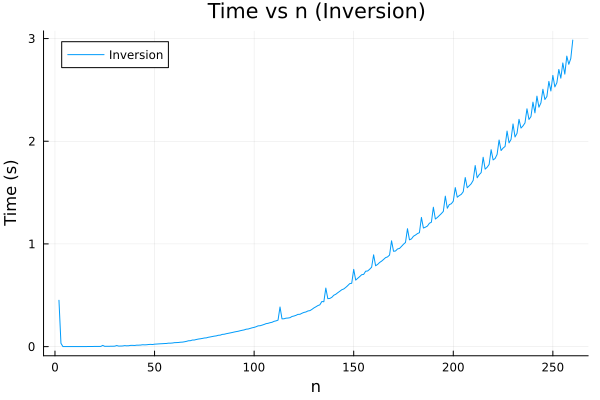

In [ ]:
plot(inv_df.n, inv_df.time, label="Inversion", xlabel="n", ylabel="Time (s)", title="Time vs n (Inversion)")

##### Wykres liczby operacji:

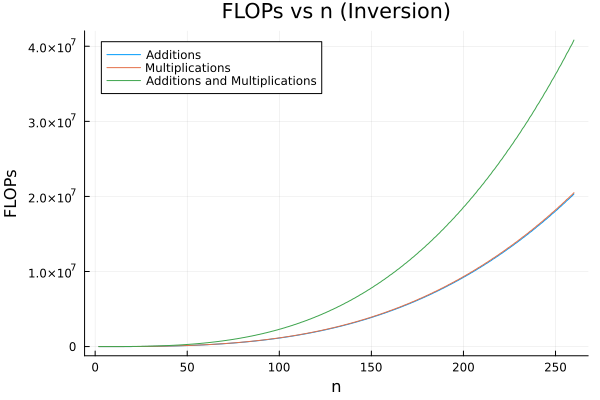

In [ ]:
plot(inv_df.n, inv_df.additions, label="Additions",  xlabel="n", ylabel="FLOPs", title="FLOPs vs n (Inversion)")
plot!(inv_df.n, inv_df.multiplications, label="Multiplications")
plot!(inv_df.n, inv_df.additions + inv_df.multiplications, label="Additions and Multiplications")

##### Wykres liczby operacji na macierzach

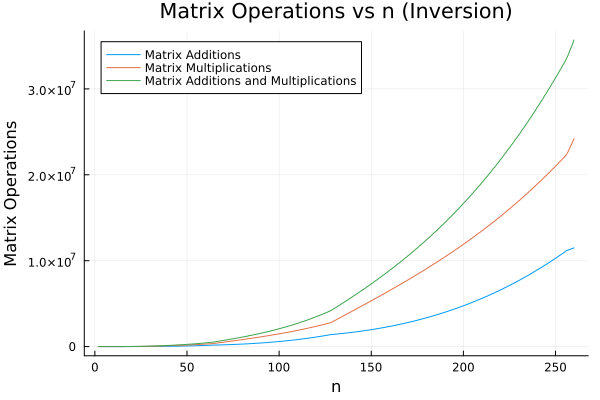

In [ ]:
plot(inv_df.n, inv_df.matrix_additions, label="Matrix Additions",  xlabel="n", ylabel="Matrix Operations", title="Matrix Operations vs n (Inversion)")
plot!(inv_df.n, inv_df.matrix_multiplications, label="Matrix Multiplications")
plot!(inv_df.n, inv_df.matrix_additions + inv_df.matrix_multiplications, label="Matrix Additions and Multiplications")

### Rekurenycjny algorytm faktoryzacji LU:

Problem faktoryzacji LU jest często przedstawiany w następujący sposób:

$$ A = LU $$

gdzie:

$$ A = \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix} $$

$$ L = \begin{bmatrix} L_{11} & 0 \\ L_{21} & L_{22} \end{bmatrix} $$

$$ U = \begin{bmatrix} U_{11} & U_{12} \\ 0 & U_{22} \end{bmatrix} $$

gdzie przez 0 w powyższych wzorach rozumiemy macierz wypełnioną 0.

Z uwagi na definicję faktoryzacji należy zaznaczyć, że macierz A musi być macierzą kwadratową, a zarówno L, jak i U muszą mieć takie same kształty co A.

Wprowadzamy również zapis funkcji faktoryzacji zwracającej macierze L oraz U:

$$ [L, U] = LU_{fact}(A) $$

Po wymnożeniu macierzy L i U otrzymujemy:

$$ LU = \begin{bmatrix} L_{11} U_{11} & L_{11} U_{12} \\ L_{21} U_{11} & L_{21} U_{12} + L_{22} U_{22} \end{bmatrix} $$

Przyrównajmy podmacierze z macierzy wynikowej do podmacierzy macierzy A:

$$ \text{I: } A_{11} = L_{11} U_{11} $$

$$ \text{II: } A_{12} = L_{11} U_{12} $$

$$ \text{III: } A_{21} = L_{21} U_{11} $$

$$ \text{IV: } A_{22} = L_{21} U_{12} + L_{22} U_{22} $$

Znalezienie podmacierzy L i U odbywa się następująco:

$$ \text{1: } [L_{11}, U_{11}] = LU_{fact}(A_{11}) $$

$$ \text{2: Mnożenie obustronne I przez } L_{11}^{-1} \text{ (lewostronne): } L_{11}^{-1} A_{11} = L_{11}^{-1} L_{11} U_{11} \implies U_{11} = L_{11}^{-1} A_{11} $$

$$ \text{3: Mnożenie obustronne II przez } L_{11}^{-1} \text{ (lewostronne): } L_{11}^{-1} A_{12} = L_{11}^{-1} L_{11} U_{12} \implies U_{12} = L_{11}^{-1} A_{12} $$

$$ \text{4: Mnożenie obustronne III przez } U_{11}^{-1} \text{ (prawostronne): } A_{21} U_{11}^{-1} = L_{21} U_{11} U_{11}^{-1} \implies L_{21} = A_{21} U_{11}^{-1} $$

$$ \text{5: Odjęcie obustrone } L_{21} U_{12} \text{ w IV: } L_{22} U_{22} = A_{22} - L_{21} U_{12} \implies L_{22} U_{22} = A_{22} - A_{21} U_{11}^{-1} L_{11}^{-1} A_{12} $$ 

$$ \text{6: } [L_{22}, U_{22}] = LU_{fact}(L_{22} U_{22}) $$

Mając na uwadze punkty I-IV, 1-6 oraz własności problemów faktoryzacji LU, jak i inwersji macierzy ustalamy jakie kształty powinny mieć podmacierze A, L oraz U:

Tymczasowo zapiszmy:

$$ A_{11} = A_{11 (b,c)} $$
$$ A_{12} = A_{12 (d,e)} $$
$$ A_{21} = A_{21 (f,g)} $$
$$ A_{22} = A_{22 (h,i)} $$

Ze wzoru 1 oraz własności faktoryzacji LU: $ A_{11 (b,c)} = A_{11 (b,b)} $

Ze wzoru 1 oraz własności faktoryzacji LU: $ L_{11} = L_{11 (b,b)} \land U_{11} = U_{11 (b,b)} $

Ze wzoru 3 oraz własności inwersji macierzy: $ U_{12} = L_{11 (b,b)}^{-1} A_{12 (d,e)} \implies d=b \land U_{12} = U_{12 (b,e)} $

Ze wzoru 4 oraz własności inwersji macierzy: $ L_{21} = A_{21 (f,g)} U_{11 (b,b)}^{-1} \implies g=b \land L_{21} = L_{21 (f,b)} $

Ze wzoru 5: $ A_{22 (h,i)} A_{21 (f,b)} U_{11 (b,b)}^{-1} L_{11 (b,b)}^{-1} A_{12 (b,e)} \implies h=f \land i=e $

Ze wzoru 5: $ L_{22} U_{22} = (L_{22} U_{22})_{(f,e)} $

Ze wzoru 6 i własności faktoryzacji LU: $ L_{22} = L_{22 (f,e)} \land U_{22} = U_{22 (f,e)} \land f=e $

Podsumowując powyższe wyprowadzenia:

$$ b=c=d=g \land e=f=h=i $$

Wiedząc już jak należy podzielić macierz A przy wykonywaniu na niej faktoryzacji LU można już przystąpić do implementacji. Dokładne wartości $ b $ oraz $ e $ mogą być dowolne, o ile $ b+e=n $ (gdzie $ n $ to rozmiar krawędzi macierzy), przy implementacji (podobnie jak w przypadku odwracania macierzy) przymujemy, że $ b = \lfloor \frac{n}{2} \rfloor $ oraz $ e = n-b $.

##### Kod faktoryzacji LU:

In [ ]:
function LU_fact(A, matmul)
    global additions, multiplications, matrix_additions, matrix_multiplications, matrix_inversions, matrix_lu_factorizations

    m = size(A)[1]
    n = size(A)[2]

    if (m != n)
        error("Something went wrong, can only LU factorize square matrixes")
    end

    matrix_lu_factorizations += 1

    if n == 1
        return A, reshape([1], 1, 1)
    end

    b = div(n,2)
    A_11 = A[1:b , 1:b]
    A_12 = A[1:b , b+1:end]
    A_21 = A[b+1:end , 1:b]
    A_22 = A[b+1:end , b+1:end]
    
    L_11, U_11 = LU_fact(A_11, matmul)
    L_11_inv = inverse(L_11, matmul)
    U_11_inv = inverse(U_11, matmul)
    L_21 = matmul(A_21, U_11_inv)
    U_12 = matmul(L_11_inv, A_12)
    P = matmul(L_21, U_12)

    S = A_22 - P

    L_22, U_22 = LU_fact(S, matmul)

    additions += size(P)[1] * size(P)[2]
    matrix_additions += 1

    return [L_11 zeros(b,n-b) ; L_21 L_22], [U_11 U_12 ; zeros(n-b,b) U_22]
end

LU_fact (generic function with 1 method)

Jeżeli wyniki testowania algorytmu LU nie znajdując się w odpowiednim pliku .csv należy uruchomić poniższy kod:

In [ ]:
function test_LU_fact(start_n, end_n, a, b, matmul)
    global additions, multiplications, matrix_additions, matrix_multiplications, matrix_inversions, matrix_lu_factorizations

    results = DataFrame(n = Int[], correct = Bool[], additions = Int[], multiplications = Int[], matrix_additions = Int[], matrix_multiplications = Int[], matrix_inversions = Int[], matrix_lu_factorizations = Int[], time = Float64[])

    for n in start_n:end_n
        additions, multiplications, matrix_additions, matrix_multiplications, matrix_inversions, matrix_lu_factorizations = 0, 0, 0, 0, 0, 0
        A = generate_random_matrix(n, n, a, b)

        tik = time()
        result_L, result_U = LU_fact(A, matmul)
        tok = time()

        correct = are_equal(result_L * result_U, A)

        push!(results, (n, correct, additions, multiplications, matrix_additions, matrix_multiplications, matrix_inversions, matrix_lu_factorizations, tok - tik))
    end
    
    return results
end;

In [ ]:
filename = "lu_fact_results_$cpu_name.csv"

if !isfile(filename)
    df = test_LU_fact(start_n, end_n, low, high, binet)
    CSV.write(filename, df);
end

"lu_fact_results_M1_Pro.csv"

Jeżeli wyniki są już w pliku .csv wystarczy załadować i wyświetlić wyniki:

In [ ]:
lu_df = CSV.read(filename, DataFrame)

259×9 DataFrame
 Row │ n      correct  additions  multiplications  matrix_additions  matrix_mu ⋯
     │ Int64  Bool     Int64      Int64            Int64             Int64     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     2     true          1                3                 1            ⋯
   2 │     3     true          5               11                 2
   3 │     4     true         22               44                19
   4 │     5     true         40               70                20
   5 │     6     true         97              155                62            ⋯
   6 │     7     true        147              227                92
   7 │     8     true        284              420               215
   8 │     9     true        362              514               216
   9 │    10     true        573              777               338            ⋯
  10 │    11     true        725              967               401
  11 │    12     true       1106             1440               671
  ⋮  │   ⋮       ⋮         ⋮             ⋮                ⋮                    ⋱
 250 │   251     true   13718887         13930589           7851522
 251 │   252     true   13967994         14182464           8030599            ⋯
 252 │   253     true   14063322         14278950           8081773
 253 │   254     true   14277997         14496033           8234554
 254 │   255     true   14410019         14629961           8316116
 255 │   256     true   14687104         14910464           8517007            ⋯
 256 │   257     true   14774230         14998102           8517008
 257 │   258     true   14976685         15202097           8600210
 258 │   259     true   15093831         15320273           8621849
 259 │   260     true   15352814         15581580           8736695            ⋯
                                                  4 columns and 238 rows omitted

##### Wykres czasu egzekucji algorytmu:

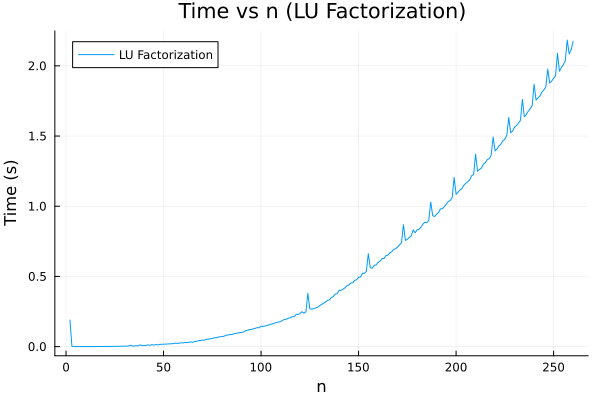

In [ ]:
plot(lu_df.n, lu_df.time, label="LU Factorization", xlabel="n", ylabel="Time (s)", title="Time vs n (LU Factorization)")

##### Wykres liczby operacji:

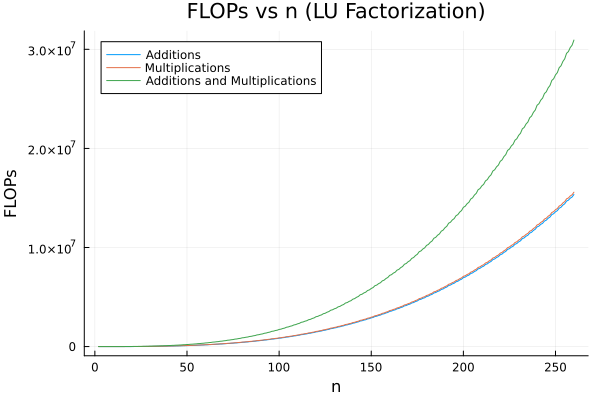

In [ ]:
plot(lu_df.n,   lu_df.additions, label="Additions",  xlabel="n", ylabel="FLOPs", title="FLOPs vs n (LU Factorization)")
plot!(lu_df.n,  lu_df.multiplications, label="Multiplications")
plot!(lu_df.n, lu_df.additions + lu_df.multiplications, label="Additions and Multiplications")

##### Wykres liczby operacji na macierzach

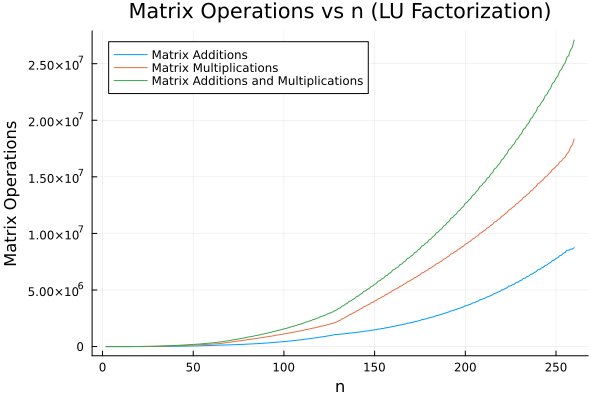

In [ ]:
plot(lu_df.n, lu_df.matrix_additions, label="Matrix Additions",  xlabel="n", ylabel="Matrix Operations", title="Matrix Operations vs n (LU Factorization)")
plot!(lu_df.n, lu_df.matrix_multiplications, label="Matrix Multiplications")
plot!(lu_df.n, lu_df.matrix_additions + lu_df.matrix_multiplications, label="Matrix Additions and Multiplications")

### Eliminacja Gaussa


$$ \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix} * \begin{bmatrix} x_{1} \\ x_{2} \end{bmatrix} =\begin{bmatrix} b_{1} \\ b_{2} \end{bmatrix} $$

$$ \begin{bmatrix} C_{11} & C_{12} \\ C_{21} & C_{22} \end{bmatrix} * \begin{bmatrix} x_{1} \\ x_{2} \end{bmatrix} = \begin{bmatrix} U_{11} & L_{11}^{-1}A_{12} \\ 0 & U_{S} \end{bmatrix} * \begin{bmatrix} x_{1} \\ x_{2} \end{bmatrix} = \begin{bmatrix} L_{11}^{-1}b_{1} \\ L_{S}^{-1}b_{2} - L_{S}^{-1}A_{21}U{11}^{-1}L_{11}^{-1}b{1} \end{bmatrix} = \begin{bmatrix} RHS_{1} \\ RHS_{2} \end{bmatrix}$$

gdzie:
- $ \begin{bmatrix} L_{11} & U_{11} \end{bmatrix} = LU(A_{11}) $
- $ L_{11}^{-1} = inverse(L_{11}) $
- $ U_{11}^{-1} = inverse(U_{11}) $
- $ S = A_{22} - A_{21}U_{11}^{-1}L_{11}^{-1}A_{12} $
- $ \begin{bmatrix} L_{S} & U_{S} \end{bmatrix} = LU(S) $
- $ C_{11} = U_{11}, C_{12} = L_{11}^{-1}A_{12}, C_{22} = U_{S} $
- $ RHS_{1} = L_{11}^{-1}b_{1} $
- $ RHS_{2} = L_{S}^{-1}b_{2} - L_{S}^{-1}A_{21}U_{11}^{-1}L_{11}^{-1}b_{1} $



In [ ]:
function gaussian_elimination(A, b, matmul)
    global additions, multiplications, matrix_additions, matrix_multiplications, matrix_inversions, matrix_lu_factorizations

    A_m, A_n = div(size(A, 1), 2), div(size(A, 2), 2)

    A11, A12, A21, A22 = A[1:A_m, 1:A_n], A[1:A_m, A_n+1:end], A[A_m+1:end, 1:A_n], A[A_m+1:end, A_n+1:end]

    L11, U11 = LU_fact(A11, matmul)
    L11_inv = inverse(L11, matmul)
    U11_inv = inverse(U11, matmul)
    S = A22 - matmul(matmul(A21, U11_inv), matmul(L11_inv, A12))
    LS, US = LU_fact(S, matmul)
    LS_inv = inverse(LS, matmul)
    C = zeros(size(A))
    C[1:A_m, 1:A_n] = U11
    C[1:A_m, A_n+1:end] = matmul(L11_inv, A12)
    C[A_m+1:end, A_n+1:end] = US

    RHS = zeros(size(b))
    RHS[1:A_m] = L11_inv * b[1:A_m] #TODO
    LS_inv_A21 = matmul(LS_inv, A21)
    U11_inv_RHS1 = U11_inv * RHS[1:A_m] #TODO
    RHS[A_m+1:end] = LS_inv * b[A_m+1:end] - LS_inv_A21 * U11_inv_RHS1 #TODO

    additions += size(S)[1] * size(S)[2] + size(RHS[A_m+1:end])[1]
    multiplications += size(L11_inv)[1] * size(L11_inv)[2] + size(U11_inv)[1] * size(U11_inv)[2]
    multiplications += size(LS_inv)[1] * size(LS_inv)[2] + size(LS_inv_A21)[1] * size(LS_inv_A21)[2]
    matrix_additions += 2
    matrix_multiplications += 4
    
    return C, RHS
end

gaussian_elimination (generic function with 1 method)

In [ ]:
function test_gaussian_elimination(start_n, end_n, low, high, matmul)
    global additions, multiplications, matrix_additions, matrix_multiplications, matrix_inversions, matrix_lu_factorizations

    results = DataFrame(n = Int[], correct = Bool[], additions = Int[], multiplications = Int[], matrix_additions = Int[], matrix_multiplications = Int[], matrix_inversions = Int[], matrix_lu_factorizations = Int[], time = Float64[])

    for n in start_n:end_n
        additions, multiplications, matrix_additions, matrix_multiplications, matrix_inversions, matrix_lu_factorizations = 0, 0, 0, 0, 0, 0

        A = generate_random_matrix(n, n, low, high)
        X = generate_random_matrix(n, 1, low, high)
        B = A*X

        tik = time()
        C, RHS = gaussian_elimination(A, B, matmul)
        tok = time()

        test1 = are_equal(inv(C) * RHS, X, max(minimum(abs.(X)) / 1000, 1e-4))
        test2 = are_equal(C*X, RHS, max(minimum(abs.(RHS)) / 1000, 1e-4))
        correct = test1 & test2

        push!(results, (n, correct, additions, multiplications, matrix_additions, matrix_multiplications, matrix_inversions, matrix_lu_factorizations, tok - tik))
    end

    return results
end;

In [ ]:
filename = "gaussian_elimination_results_$cpu_name.csv"

if !isfile(filename)
    df = test_gaussian_elimination(start_n, end_n, low, high, binet)
    CSV.write(filename, df);
end

"gaussian_elimination_results_M1_Pro.csv"

In [ ]:
gaussian_elimination_df = CSV.read(filename, DataFrame)

259×9 DataFrame
 Row │ n      correct  additions  multiplications  matrix_additions  matrix_mu ⋯
     │ Int64  Bool     Int64      Int64            Int64             Int64     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     2     true          2                9                 2            ⋯
   2 │     3     true         11               32                 7
   3 │     4     true         34               83                30
   4 │     5     true         73              149                44
   5 │     6     true        148              271                98            ⋯
   6 │     7     true        251              427               171
   7 │     8     true        424              682               322
   8 │     9     true        591              902               366
   9 │    10     true        862             1258               518            ⋯
  10 │    11     true       1169             1654               675
  11 │    12     true       1640             2257               999
  ⋮  │   ⋮       ⋮         ⋮             ⋮                ⋮                    ⋱
 250 │   251     true   19931335         20276548          11408678
 251 │   252     true   20227692         20576553          11619129            ⋯
 252 │   253     true   20421817         20773090          11736320
 253 │   254     true   20684498         21039066          11921105
 254 │   255     true   20928803         21286667          12077983
 255 │   256     true   21254656         21616832          12311514            ⋯
 256 │   257     true   21439831         21803672          12344666
 257 │   258     true   21691822         22058104          12444638
 258 │   259     true   21920909         22289512          12504687
 259 │   260     true   22230202         22602037          12636823            ⋯
                                                  4 columns and 238 rows omitted

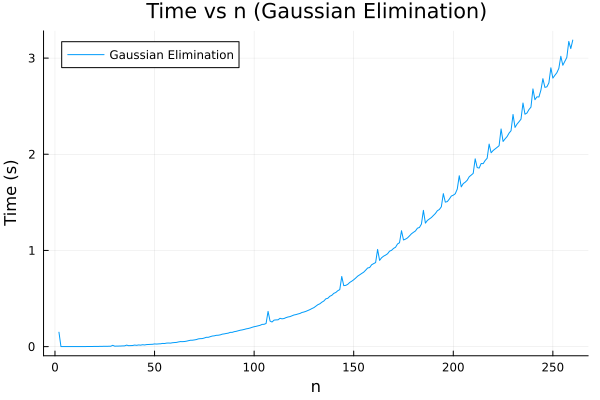

In [ ]:
plot(gaussian_elimination_df.n, gaussian_elimination_df.time, label="Gaussian Elimination", xlabel="n", ylabel="Time (s)", title="Time vs n (Gaussian Elimination)")

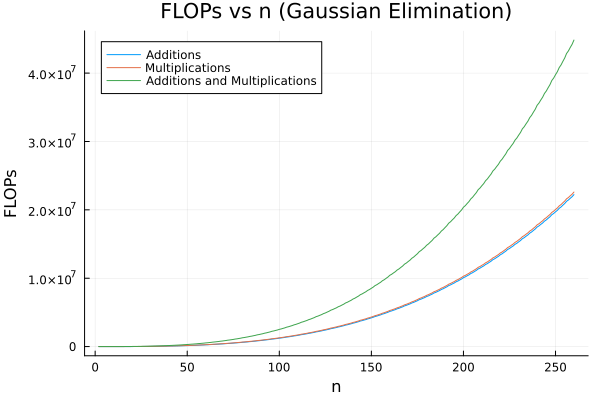

In [ ]:
plot(gaussian_elimination_df.n,   gaussian_elimination_df.additions, label="Additions",  xlabel="n", ylabel="FLOPs", title="FLOPs vs n (Gaussian Elimination)")
plot!(gaussian_elimination_df.n,  gaussian_elimination_df.multiplications, label="Multiplications")
plot!(gaussian_elimination_df.n, gaussian_elimination_df.additions + gaussian_elimination_df.multiplications, label="Additions and Multiplications",)

##### Wykres liczby operacji na macierzach

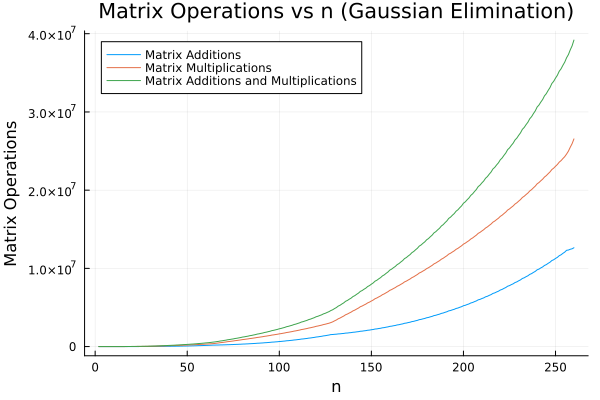

In [ ]:
plot(gaussian_elimination_df.n, gaussian_elimination_df.matrix_additions, label="Matrix Additions",  xlabel="n", ylabel="Matrix Operations", title="Matrix Operations vs n (Gaussian Elimination)")
plot!(gaussian_elimination_df.n, gaussian_elimination_df.matrix_multiplications, label="Matrix Multiplications")
plot!(gaussian_elimination_df.n, gaussian_elimination_df.matrix_additions + gaussian_elimination_df.matrix_multiplications, label="Matrix Additions and Multiplications")

### Wyznacznik Macierzy

$$ \text{det}(A) = l_{11} * ... * l_{nn} * u_{11} * ... * u_{nn} $$

gdzie:
- $ l_{ii} $ to przekątna macierzy L
- $ u_{ii} $ to przekątna U

In [ ]:
function determinant(A, matmul)
    global additions, multiplications, matrix_multiplications
    
    m, n = size(A)
    if m != n
        error("The matrix must be square to calculate the determinant")
    end

    L, U = LU_fact(A, matmul)

    determinant_value = 1

    for i in 1:n
        determinant_value *= L[i,i] * U[i,i]
        multiplications += 1
        matrix_multiplications += 1
    end

    return determinant_value
end;

In [ ]:
function test_determinant(start_n, end_n, low, high, matmul)
    global additions, multiplications, matrix_additions, matrix_multiplications, matrix_inversions, matrix_lu_factorizations
    
    results = DataFrame(n = Int[],  determinant = Float64[], correct = Bool[], additions = Int[], multiplications = Int[], matrix_additions = Int[], matrix_multiplications = Int[], matrix_inversions = Int[], matrix_lu_factorizations = Int[], time = Float64[])

    for n in start_n:end_n
        additions, multiplications, matrix_additions, matrix_multiplications, matrix_inversions, matrix_lu_factorizations = 0, 0, 0, 0, 0, 0

        A = generate_random_matrix(n, n, low, high)

        tik = time()
        determinant_value = determinant(A, matmul)
        tok = time()
        
        correct = are_equal(determinant_value, det(A), abs(det(A)) / 1000)

        push!(results, (n, determinant_value, correct, additions, multiplications, matrix_additions, matrix_multiplications, matrix_inversions, matrix_lu_factorizations, tok - tik))
    end

    return results
end;

In [ ]:
filename = "determinant_results_$cpu_name.csv"

if !isfile(filename)
    df = test_determinant(start_n, end_n, low, high, binet)
    CSV.write(filename, df);
end

"determinant_results_M1_Pro.csv"

In [ ]:
determinant_df = CSV.read(filename, DataFrame)

259×10 DataFrame
 Row │ n      determinant   correct  additions  multiplications  matrix_additi ⋯
     │ Int64  Float64       Bool     Int64      Int64            Int64         ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     2   0.254926        true          1                5                ⋯
   2 │     3   0.0224711       true          5               14
   3 │     4   0.0473507       true         22               48
   4 │     5   0.00464695      true         40               75
   5 │     6   0.00278744      true         97              161                ⋯
   6 │     7  -0.000805543     true        147              234
   7 │     8   0.0243966       true        284              428
   8 │     9  -0.0132548       true        362              523
   9 │    10  -0.0472506       true        573              787                ⋯
  10 │    11  -0.0182152       true        725              978
  11 │    12   0.0235015       true       1106             1452
  ⋮  │   ⋮         ⋮           ⋮         ⋮             ⋮                ⋮      ⋱
 250 │   251  -6.81869e111     true   13718887         13930840           7851
 251 │   252   3.27235e112     true   13967994         14182716           8030 ⋯
 252 │   253   1.14165e113     true   14063322         14279203           8081
 253 │   254  -5.76558e114     true   14277997         14496287           8234
 254 │   255  -1.62552e114     true   14410019         14630216           8316
 255 │   256   7.97578e114     true   14687104         14910720           8517 ⋯
 256 │   257  -2.4849e114      true   14774230         14998359           8517
 257 │   258   1.72059e116     true   14976685         15202355           8600
 258 │   259   6.66718e117     true   15093831         15320532           8621
 259 │   260   1.8341e119      true   15352814         15581840           8736 ⋯
                                                  5 columns and 238 rows omitted

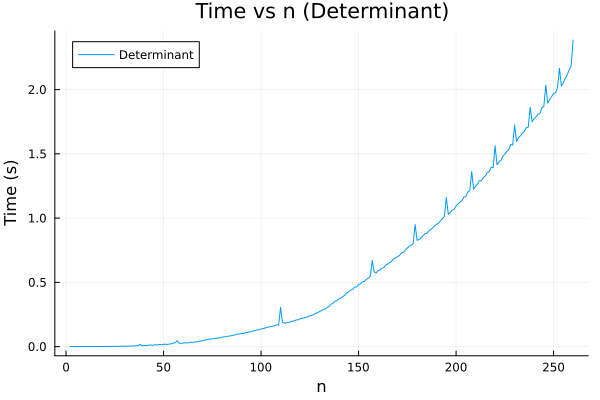

In [ ]:
plot(determinant_df.n, determinant_df.time, label="Determinant", xlabel="n", ylabel="Time (s)", title="Time vs n (Determinant)")

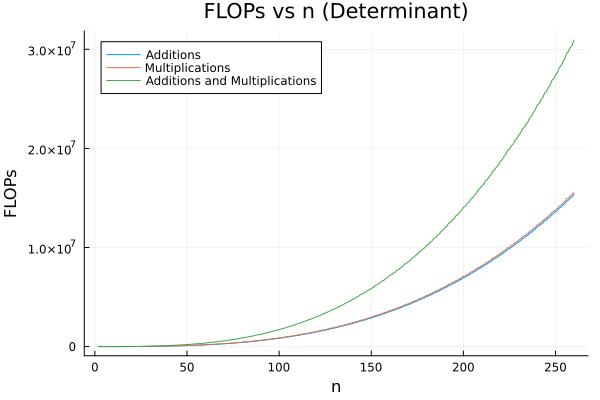

In [ ]:
plot(determinant_df.n,   determinant_df.additions, label="Additions",  xlabel="n", ylabel="FLOPs", title="FLOPs vs n (Determinant)")
plot!(determinant_df.n,  determinant_df.multiplications, label="Multiplications")
plot!(determinant_df.n, determinant_df.additions + determinant_df.multiplications, label="Additions and Multiplications",)

##### Wykres liczby operacji na macierzach

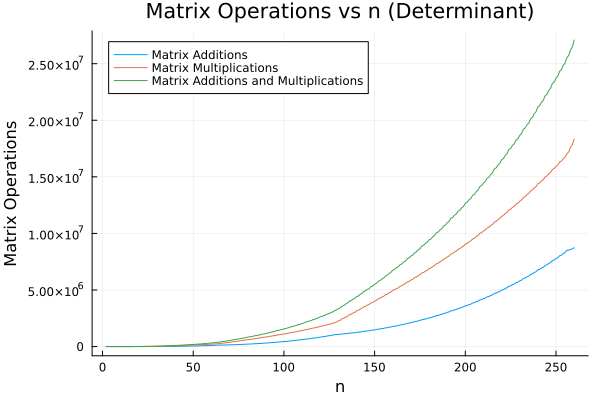

In [ ]:
plot(determinant_df.n, determinant_df.matrix_additions, label="Matrix Additions",  xlabel="n", ylabel="Matrix Operations", title="Matrix Operations vs n (Determinant)")
plot!(determinant_df.n, determinant_df.matrix_multiplications, label="Matrix Multiplications")
plot!(determinant_df.n, determinant_df.matrix_additions + determinant_df.matrix_multiplications, label="Matrix Additions and Multiplications")

# Złożoność obliczeniowa algorytmów:

Bazując na wykresach czasu egzekucji algorytmów oraz liczb operacji, można dojść do wniosku, że złożoności algorytmów odwracania macierzy oraz faktoryzacji są w bardzo dużej mierze zależne od użytego algorytmu mnożenia macierzy. Użyty wyżej algorytm Binet'a ma złożność ~$ O(n^{3}) $, co dość dobrze widać na wykresach:

##### Dla algorytmu odwracania macierzy:

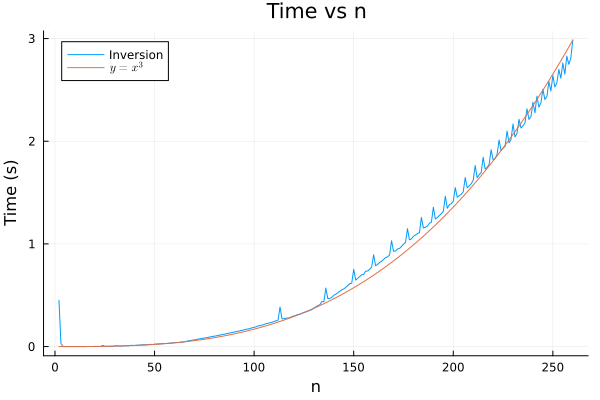

In [ ]:
plot(inv_df.n, inv_df.time, label="Inversion", xlabel="n", ylabel="Time (s)", title="Time vs n")
coef = inv_df[end, :time] / (end_n^3)
plot!(inv_df.n, x->coef*(x^3), label=L"$y=x^{3}$")

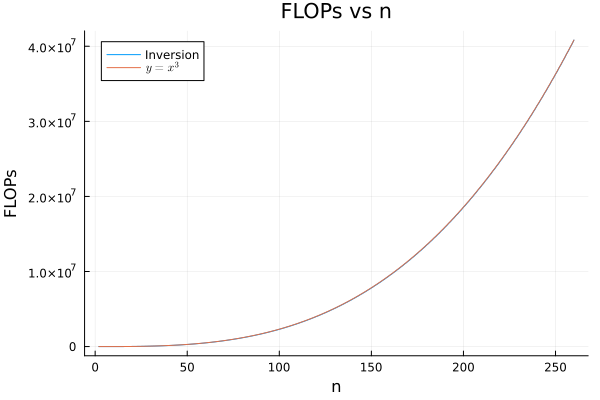

In [ ]:
plot(inv_df.n, inv_df.additions + inv_df.multiplications, label="Inversion", xlabel="n", ylabel="FLOPs", title="FLOPs vs n")
coef = (inv_df[end, :additions]+inv_df[end, :multiplications]) / (end_n^3)
plot!(inv_df.n, x->coef*(x^3), label=L"$y=x^{3}$")

##### Dla algorytmu faktoryzacji LU:

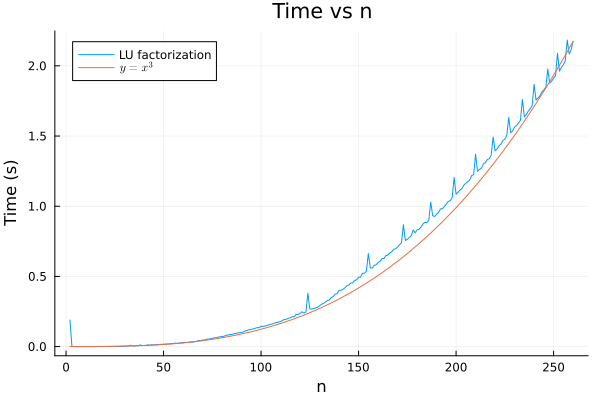

In [ ]:
plot(lu_df.n, lu_df.time, label="LU factorization", xlabel="n", ylabel="Time (s)", title="Time vs n")
coef = lu_df[end, :time] / (end_n^3)
plot!(lu_df.n, x->coef*(x^3), label=L"$y=x^{3}$")

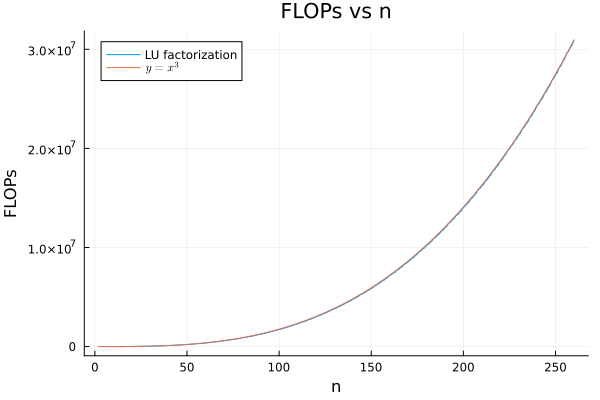

In [ ]:
plot(lu_df.n, lu_df.additions + lu_df.multiplications, label="LU factorization", xlabel="n", ylabel="FLOPs", title="FLOPs vs n")
coef = (lu_df[end, :additions]+lu_df[end, :multiplications]) / (end_n^3)
plot!(lu_df.n, x->coef*(x^3), label=L"$y=x^{3}$")

##### Dla eliminacji Gaussa:

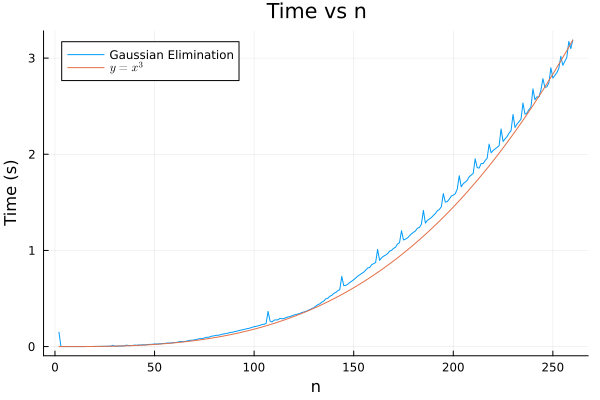

In [ ]:
plot(gaussian_elimination_df.n, gaussian_elimination_df.time, label="Gaussian Elimination", xlabel="n", ylabel="Time (s)", title="Time vs n")
coef = gaussian_elimination_df[end, :time] / (end_n^3)
plot!(gaussian_elimination_df.n, x->coef*(x^3), label=L"$y=x^{3}$")

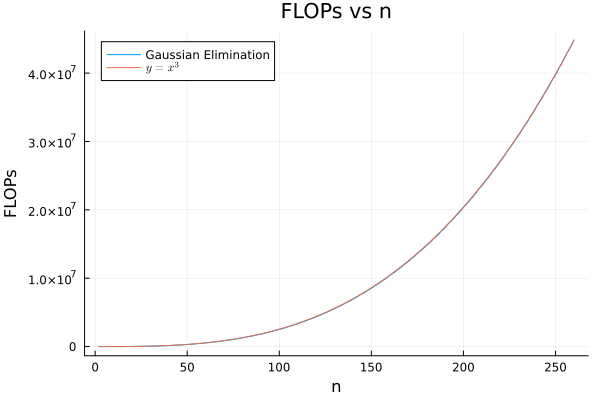

In [ ]:
plot(gaussian_elimination_df.n, gaussian_elimination_df.additions + gaussian_elimination_df.multiplications, label="Gaussian Elimination", xlabel="n", ylabel="FLOPs", title="FLOPs vs n")
coef = (gaussian_elimination_df[end, :additions]+gaussian_elimination_df[end, :multiplications]) / (end_n^3)
plot!(gaussian_elimination_df.n, x->coef*(x^3), label=L"$y=x^{3}$")

##### Dla algorytmu liczenia wyznacznika:

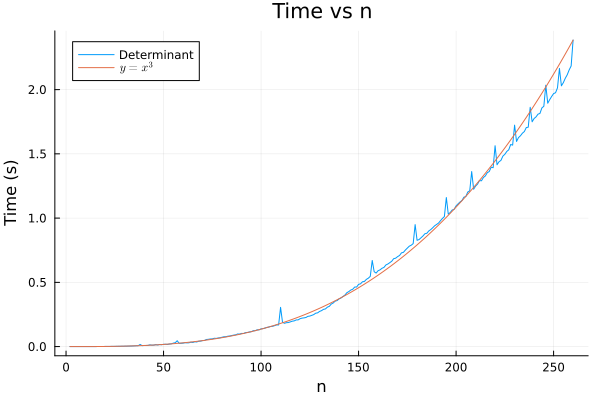

In [ ]:
plot(determinant_df.n, determinant_df.time, label="Determinant", xlabel="n", ylabel="Time (s)", title="Time vs n")
coef = determinant_df[end, :time] / (end_n^3)
plot!(determinant_df.n, x->coef*(x^3), label=L"$y=x^{3}$")

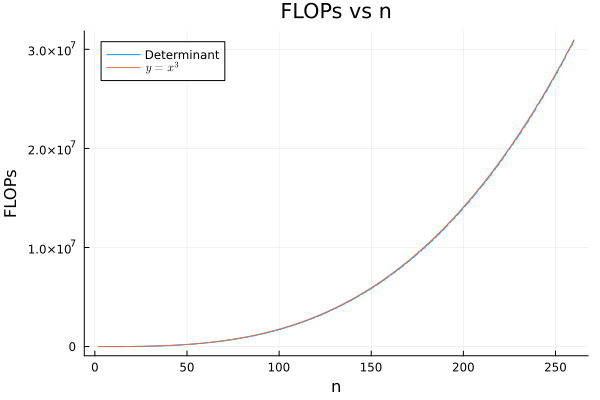

In [ ]:
plot(determinant_df.n, determinant_df.additions + determinant_df.multiplications, label="Determinant", xlabel="n", ylabel="FLOPs", title="FLOPs vs n")
coef = (determinant_df[end, :additions]+determinant_df[end, :multiplications]) / (end_n^3)
plot!(determinant_df.n, x->coef*(x^3), label=L"$y=x^{3}$")

In [ ]:
savefig("LU_fact_binet_time_complexity_comparison(ops)_i5_13400f.png");

Aby być pewniejszym tezy przedstawionej na początku sekcji warto sprawdzić jak zmieni się złożność w przypadku użyciu algorytmu Strassen'a zamiast algorytmu Binet'a do mnożenia macierzy. Algorytm Strassen'a ma złożoność ~$O(7^{\lceil log_{2}n \rceil})$, więc odpowiednio powinny zmienić się czasy działań i liczby operacji na macierzach algorytmów.

In [ ]:
function is_square(A)
    return size(A)[1] == size(A)[2]
end


function pad_with_zeros(A,p,r)
    m, n = size(A)
    return [A zeros(m,r-n) ; zeros(p-m,r)]
end


function strassen(A,B)
    if size(A)[2] != size(B)[1]
        return [], 0, 0
    end
    tm = size(A)[1]
    tp = size(B)[2]
    if !is_square(A) || !is_square(B)
        m, n = size(A)
        p = size(B)[2]
        pad_num = max(m,n,p)
        A = pad_with_zeros(A,pad_num,pad_num)
        B = pad_with_zeros(B,pad_num,pad_num)
    end  

    
    function internal_strassen(A_,B_)
        global additions, multiplications, matrix_additions, matrix_multiplications

        local n = size(A_)[1]
        if n == 1
            multiplications += 1
            return [A_[1,1]*B_[1,1]]
        else
            n_divby_2 = div(n,2)
            if n%2 != 0
                A_ = [A_ zeros(n,1) ; zeros(1,n+1)]
                B_ = [B_ zeros(n,1) ; zeros(1,n+1)]
                n_divby_2 = div(n+1,2)
            end
            A_11 = A_[1:n_divby_2 , 1:n_divby_2]
            A_12 = A_[1:n_divby_2 , n_divby_2+1:end]
            A_21 = A_[n_divby_2+1:end , 1:n_divby_2]
            A_22 = A_[n_divby_2+1:end , n_divby_2+1:end]
            B_11 = B_[1:n_divby_2 , 1:n_divby_2]
            B_12 = B_[1:n_divby_2 , n_divby_2+1:end]
            B_21 = B_[n_divby_2+1:end , 1:n_divby_2]
            B_22 = B_[n_divby_2+1:end , n_divby_2+1:end]
            P_1 = internal_strassen((A_11+A_22),(B_11+B_22))
            P_2 = internal_strassen((A_21+A_22),B_11)
            P_3 = internal_strassen(A_11,(B_12-B_22))
            P_4 = internal_strassen(A_22,(B_21-B_11))
            P_5 = internal_strassen((A_11+A_12),B_22)
            P_6 = internal_strassen((A_21-A_11),(B_11+B_12))
            P_7 = internal_strassen((A_12-A_22),(B_21+B_22))

            additions += 18 * size(A_11)[1] * size(A_11)[2]
            matrix_additions += 18
            matrix_multiplications += 7

            return [P_1+P_4-P_5+P_7 P_3+P_5 ; P_2+P_4 P_1-P_2+P_3+P_6][1:n , 1:n]
        end
    end    

    return internal_strassen(A,B)[1:tm , 1:tp]

end


strassen (generic function with 1 method)

In [ ]:
filename = "inverse_results_strassen_$cpu_name.csv"

if !isfile(filename)
    df = test_matrix_inversion(start_n, end_n, low, high, strassen)
    CSV.write(filename, df);
end

"inverse_results_strassen_M1_Pro.csv"

In [ ]:
inv_df_s = CSV.read(filename, DataFrame)

259×8 DataFrame
 Row │ n      correct  additions  multiplications  matrix_additions  matrix_mu ⋯
     │ Int64  Bool     Int64      Int64            Int64             Int64     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     2     true          2                7                 2            ⋯
   2 │     3     true        115               50               112
   3 │     4     true        138               63               132
   4 │     5     true       1336              358               998
   5 │     6     true       1634              443              1234            ⋯
   6 │     7     true       1664              456              1254
   7 │     8     true       1694              469              1274
   8 │     9     true      11001             2528              7432
   9 │    10     true      13558             3117              9180            ⋯
  10 │    11     true      13867             3202              9416
  11 │    12     true      14176             3287              9652
  ⋮  │   ⋮       ⋮         ⋮             ⋮                ⋮                    ⋱
 250 │   251     true   47096847          8070298          24206144
 251 │   252    false   47098496          8070311          24206164            ⋯
 252 │   253    false   47112731          8070324          24206184
 253 │   254     true   47115536          8070337          24206204
 254 │   255    false   47116057          8070350          24206224
 255 │   256    false   47116578          8070363          24206244            ⋯
 256 │   257    false  209673298         42659170         127972646
 257 │   258     true  256115078         52541687         157620178
 258 │   259     true  262747682         53953476         161855526
 259 │   260    false  269380286         55365265         166090874            ⋯
                                                  3 columns and 238 rows omitted

In [ ]:
filename = "lu_fact_results_strassen_$cpu_name.csv"

if !isfile(filename)
    df = test_LU_fact(start_n, end_n, low, high, strassen)
    CSV.write(filename, df);
end

"lu_fact_results_strassen_M1_Pro.csv"

In [ ]:
lu_df_s = CSV.read(filename, DataFrame)

259×9 DataFrame
 Row │ n      correct  additions  multiplications  matrix_additions  matrix_mu ⋯
     │ Int64  Bool     Int64      Int64            Int64             Int64     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     2     true          1                3                 1            ⋯
   2 │     3     true         59               24                56
   3 │     4     true         64               41                61
   4 │     5     true        667              188               494
   5 │     6     true        951              295               769            ⋯
   6 │     7     true        963              312               774
   7 │     8     true       1014              355               819
   8 │     9     true       5676             1384              3898
   9 │    10     true       8675             2121              6063            ⋯
  10 │    11     true       8970             2228              6338
  11 │    12     true       9850             2505              7085
  ⋮  │   ⋮       ⋮         ⋮             ⋮                ⋮                    ⋱
 250 │   251     true   38270520          6683270          20019728
 251 │   252    false   38273858          6683417          20019933            ⋯
 252 │   253    false   38281449          6683538          20020098
 253 │   254    false   38282461          6683685          20020303
 254 │   255     true   38283347          6683832          20020508
 255 │   256    false   38284510          6684005          20020753            ⋯
 256 │   257    false  119563129         23978408          71903954
 257 │   258     true  177609597         36331555         108963349
 258 │   259     true  185897367         38096292         114257514
 259 │   260    false  207449568         42684607         128022375            ⋯
                                                  4 columns and 238 rows omitted

In [ ]:
filename = "gaussian_elimination_results_strassen_$cpu_name.csv"

if !isfile(filename)
    df = test_gaussian_elimination(start_n, end_n, low, high, strassen)
    CSV.write(filename, df);
end

"gaussian_elimination_results_strassen_M1_Pro.csv"

In [ ]:
gaussian_elimination_df_s = CSV.read(filename, DataFrame)

259×9 DataFrame
 Row │ n      correct  additions  multiplications  matrix_additions  matrix_mu ⋯
     │ Int64  Bool     Int64      Int64            Int64             Int64     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     2     true          2                9                 2            ⋯
   2 │     3     true         99               53                95
   3 │     4     true        104               78               100
   4 │     5     true       1181              359               895
   5 │     6     true       1465              479              1170            ⋯
   6 │     7     true       1501              519              1195
   7 │     8     true       1552              580              1240
   8 │     9     true      10113             2505              6949
   9 │    10     true      13112             3265              9114            ⋯
  10 │    11     true      13706             3473              9625
  11 │    12     true      14586             3778             10372
  ⋮  │   ⋮       ⋮         ⋮             ⋮                ⋮                    ⋱
 250 │   251    false   54543016          9545987          28416871
 251 │   252     true   54546354          9546762          28417076            ⋯
 252 │   253    false   54558784          9547275          28417261
 253 │   254    false   54559796          9548055          28417466
 254 │   255     true   54560949          9548597          28417691
 255 │   256     true   54562112          9549408          28417936            ⋯
 256 │   257     true  205505243         41667971         124772443
 257 │   258    false  263551711         54021761         161831838
 258 │   259     true  278471827         57198675         171361351
 259 │   260    false  300024028         61787638         185126212            ⋯
                                                  4 columns and 238 rows omitted

In [ ]:
filename = "determinant_results_strassen_$cpu_name.csv"

if !isfile(filename)
    df = test_determinant(start_n, end_n, low, high, strassen)
    CSV.write(filename, df);
end

"determinant_results_strassen_M1_Pro.csv"

In [ ]:
determinant_df_s = CSV.read(filename, DataFrame)

259×10 DataFrame
 Row │ n      determinant   correct  additions  multiplications  matrix_additi ⋯
     │ Int64  Float64       Bool     Int64      Int64            Int64         ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     2   0.0519172       true          1                5                ⋯
   2 │     3  -0.36609         true         59               27
   3 │     4   0.0287636       true         64               45
   4 │     5  -0.266135        true        667              193
   5 │     6  -0.00586669      true        951              301                ⋯
   6 │     7   0.00533188      true        963              319
   7 │     8   0.00315822      true       1014              363
   8 │     9   0.00661739      true       5676             1393              3
   9 │    10   0.00504056      true       8675             2131              6 ⋯
  10 │    11  -0.00548874      true       8970             2239              6
  11 │    12  -0.000933711     true       9850             2517              7
  ⋮  │   ⋮         ⋮           ⋮         ⋮             ⋮                ⋮      ⋱
 250 │   251   2.0347e113      true   38270520          6683521          20019
 251 │   252  -1.96434e113     true   38273858          6683669          20019 ⋯
 252 │   253  -1.51223e114     true   38281449          6683791          20020
 253 │   254   8.72295e113     true   38282461          6683939          20020
 254 │   255   2.53041e116     true   38283347          6684087          20020
 255 │   256  -9.68028e113     true   38284510          6684261          20020 ⋯
 256 │   257   7.31222e116     true  119563129         23978665          71903
 257 │   258  -1.52097e116     true  177609597         36331813         108963
 258 │   259   7.60447e117     true  185897367         38096551         114257
 259 │   260  -2.04332e117     true  207449568         42684867         128022 ⋯
                                                  5 columns and 238 rows omitted

Sprawdźmy jak zmieniła się złożoność:

##### Dla algorytmu odwracania macierzy:

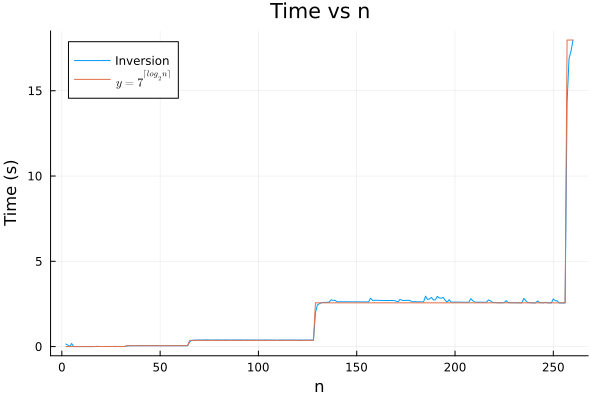

In [ ]:
plot(inv_df_s.n, inv_df_s.time, label="Inversion", xlabel="n", ylabel="Time (s)", title="Time vs n")
coef = inv_df_s[end, :time] / (7^ceil(log2(end_n)))
plot!(inv_df_s.n, x->coef*(7^ceil(log2(x))), label=L"$y=7^{ \lceil log_{2}n \rceil }$")

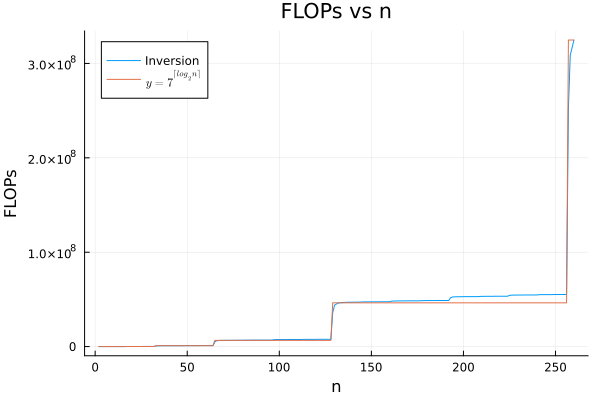

In [ ]:
plot(inv_df_s.n, inv_df_s.additions + inv_df_s.multiplications, label="Inversion", xlabel="n", ylabel="FLOPs", title="FLOPs vs n")
coef = (inv_df_s[end, :additions]+inv_df_s[end, :multiplications]) / (7^ceil(log2(end_n)))
plot!(inv_df_s.n, x->coef*(7^ceil(log2(x))), label=L"$y=7^{ \lceil log_{2}n \rceil }$")

##### Dla algorytmu faktoryzacji LU:

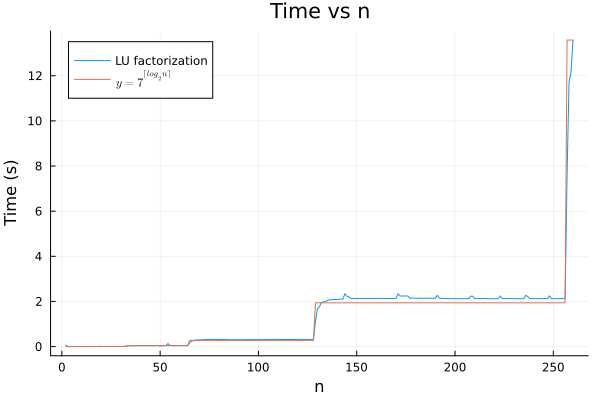

In [ ]:
plot(lu_df_s.n, lu_df_s.time, label="LU factorization", xlabel="n", ylabel="Time (s)", title="Time vs n")
coef = lu_df_s[end, :time] / (7^ceil(log2(end_n)))
plot!(lu_df_s.n, x->coef*(7^ceil(log2(x))), label=L"$y=7^{ \lceil log_{2}n \rceil }$")

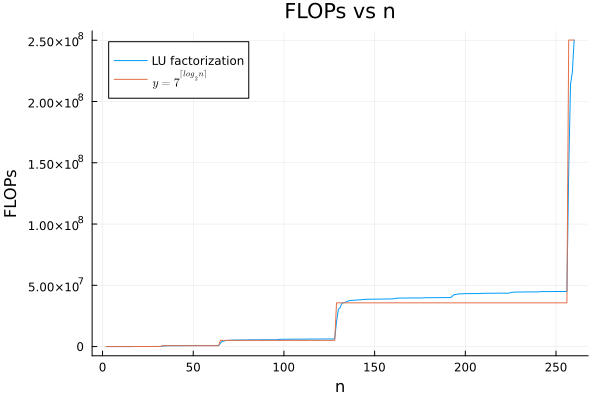

In [ ]:
plot(lu_df_s.n, lu_df_s.additions + lu_df_s.multiplications, label="LU factorization", xlabel="n", ylabel="FLOPs", title="FLOPs vs n")
coef = (lu_df_s[end, :additions]+lu_df_s[end, :multiplications]) / (7^ceil(log2(end_n)))
plot!(lu_df_s.n, x->coef*(7^ceil(log2(x))), label=L"$y=7^{ \lceil log_{2}n \rceil }$")

##### Dla alogrytmu Eliminacji Gaussa:

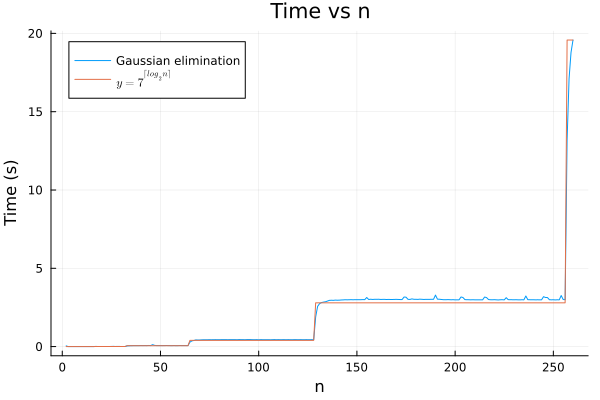

In [ ]:
plot(gaussian_elimination_df_s.n, gaussian_elimination_df_s.time, label="Gaussian elimination", xlabel="n", ylabel="Time (s)", title="Time vs n")
coef = gaussian_elimination_df_s[end, :time] / (7^ceil(log2(end_n)))
plot!(gaussian_elimination_df_s.n, x->coef*(7^ceil(log2(x))), label=L"$y=7^{ \lceil log_{2}n \rceil }$")

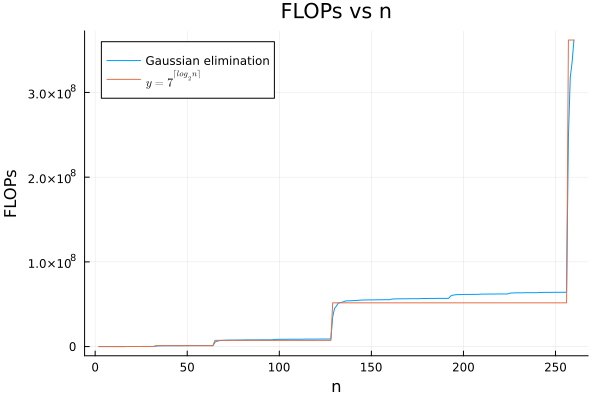

In [ ]:
plot(gaussian_elimination_df_s.n, gaussian_elimination_df_s.additions + gaussian_elimination_df_s.multiplications, label="Gaussian elimination", xlabel="n", ylabel="FLOPs", title="FLOPs vs n")
coef = (gaussian_elimination_df_s[end, :additions]+gaussian_elimination_df_s[end, :multiplications]) / (7^ceil(log2(end_n)))
plot!(gaussian_elimination_df_s.n, x->coef*(7^ceil(log2(x))), label=L"$y=7^{ \lceil log_{2}n \rceil }$")

##### Dla algorytmu liczenia wyznacznika:

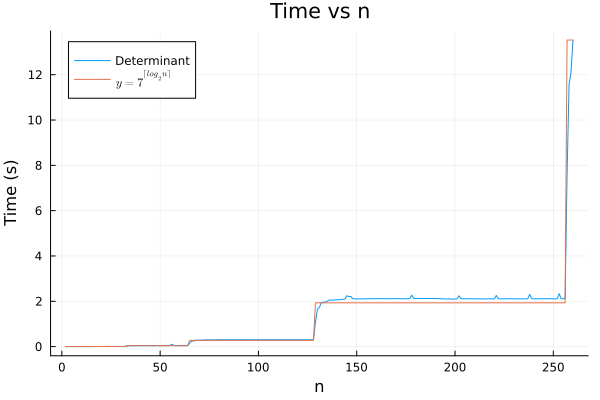

In [ ]:
plot(determinant_df_s.n, determinant_df_s.time, label="Determinant", xlabel="n", ylabel="Time (s)", title="Time vs n")
coef = determinant_df_s[end, :time] / (7^ceil(log2(end_n)))
plot!(determinant_df_s.n, x->coef*(7^ceil(log2(x))), label=L"$y=7^{ \lceil log_{2}n \rceil }$")

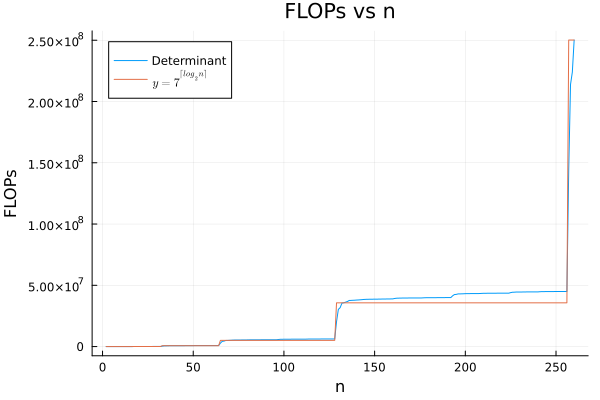

In [ ]:
plot(determinant_df_s.n, determinant_df_s.additions + determinant_df_s.multiplications, label="Determinant", xlabel="n", ylabel="FLOPs", title="FLOPs vs n")
coef = (determinant_df_s[end, :additions] + determinant_df_s[end, :multiplications]) / (7^ceil(log2(end_n)))
plot!(determinant_df_s.n, x->coef*(7^ceil(log2(x))), label=L"$y=7^{ \lceil log_{2}n \rceil }$")

##### Wnioski na temat złożności obliczeniowej:

Jak widać po wykresach zamieszczonych w tej sekcji, złożność powyszych algorytmów jest ściśle związana z użytym algorytmem mnożenia macierzy. Przy użyciu algorytmu Binet'a złożoność była ~$ O(n^{3}) $, natomiast dla Strassena: ~$ O(7^{ \lceil log_{2}n \rceil }) $, a są to właśnie złożności wspomnianych algorytmów mnożenia.

In [ ]:
savefig("LU_fact_strassen_time_complexity_comparison(exec_time).png");

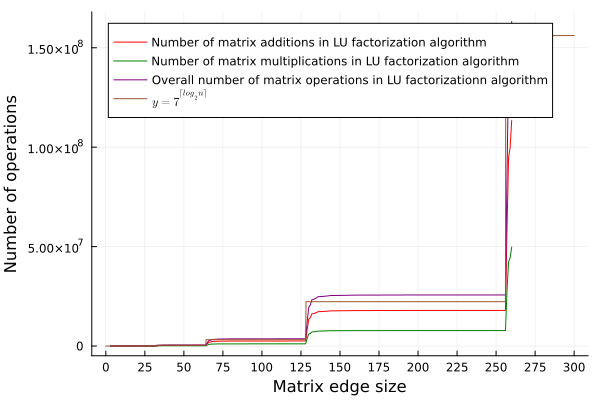

In [ ]:
coef = (lu_df_s[end, :additions]+inv_df[end, :multiplications]) / (7^ceil(log2(final_n)))
@df lu_df_s plot(:n, :additions, label="Number of matrix additions in LU factorization algorithm", xlabel="Matrix edge size", ylabel="Number of operations", color=:red, xticks=0:25:300)
@df lu_df_s plot!(:n, :multiplications, label="Number of matrix multiplications in LU factorization algorithm", color=:green)
@df lu_df_s plot!(:n, lu_df_s.additions+lu_df_s.multiplications, label="Overall number of matrix operations in LU factorizationn algorithm", color=:purple)
plot!(0:0.25:300, x->coef*(7^ceil(log2(x))), label=L"$y=7^{ \lceil log_{2}n \rceil }$", color=:sienna)

In [ ]:
savefig("LU_fact_strassen_time_complexity_comparison(ops).png");

##### Wnioski na temat złożności obliczeniowej:

Jak widać po wykresach zamieszczonych w tej sekcji, złożność algorytmów inwersji macierzy oraz faktoryzacji LU jest ściśle związana z użytym algorytmem mnożenia macierzy. Przy użyciu algorytmu Binet'a złożoność była ~$ O(n^{3}) $, natomiast dla Strassena: ~$ O(7^{ \lceil log_{2}n \rceil }) $, a są to właśnie złożności wspomnianych algorytmów mnożenia.